# Out-of-sample forecasting experiments

We conduct out-of-sample forecasting experiments to understand what kind of text data (topics, sentiment, or uncertainty) helps improve forecasts of three quarterly variables (GDP, Investment, and Consumption) more.

In this notebook, we evaluate the performance of dynamic factor models (DFM) using hard data, survey information, and 10 topics most highly correlated with Investment growth (out of 200 topics estimated on articles published before 2008 using all sources). We forecast Investment growth and integrate text data into economic forecasting.

## Experiment Details

- **Data Sources:** Hard data, surveys, 10 topics (<=2007, 200 topics, all sources).
- **Forecast Target:** Investment growth.
- **Model:** Dynamic Factor Models (DFM).
- **Parameters Explored:**
  - **Number of Global Factors:** 1 to 3
  - **Factor Order:** 1 to 3 (for each number of factors)

In [1]:
import os
import time
import datetime
import pandas as pd
import DFM_function

# Define inputs common to all models
q_var = 'Investment'               # quarterly variable being forecasted
additional_factors = None          # or "all" or e.g. ['Labor market']
start = '1991-04'
text_type = "topics"
estimation_period = "2007"
num_topics = "200"
source = "all"
with_text = True

# Generate list of forecast_month strings for quarters from 2008Q1 to 2018Q4
# forecast_month is set to the month corresponding to quarter-end:
# Q1: 'YYYY-03', Q2: 'YYYY-06', Q3: 'YYYY-09', Q4: 'YYYY-12'
forecast_months = []
for year in range(2008, 2019):
    forecast_months.extend([f"{year}-03", f"{year}-06", f"{year}-09", f"{year}-12"])
    
# Define the vintage column names 
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Create directories to save forecasts and MSE results
os.makedirs(f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_{q_var}", exist_ok=True)
os.makedirs(f"../MSE/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_{q_var}", exist_ok=True)

# Load the actual growth data
actual_growth_file = f"../{q_var}_growth_actual.csv"
actual_growth = pd.read_csv(actual_growth_file)

# Record overall start time
overall_start = time.time()

# Loop over the number of factors and factor order values from 1 to 3
for num_factors in range(1, 4):  # Varying number of Global factors: 1, 2, 3
    for order in range(1, 4):    # Varying factor order: 1, 2, 3
        
        # Define model-specific parameters
        factor_multiplicities = {'Global': num_factors}
        factor_orders = {'Global': order}

        # Prepare lists to store each quarter's forecasts and row labels
        forecasts_all_quarters = []
        row_labels = []
        
        # Start timing for this model
        start_time = time.time()

        # Loop over each forecast month, get the forecasts, and store the results
        for fm in forecast_months:
            # Use the forecast_month string as the row label
            row_labels.append(fm)

            # Run the forecast function for this quarter
            forecasts_dict = DFM_function.get_forecasts(
                forecast_month = fm,
                q_var = q_var,
                additional_factors = additional_factors,
                factor_multiplicities = factor_multiplicities,
                factor_orders = factor_orders,
                start = start,
                text_type = text_type,
                estimation_period = estimation_period,
                num_topics = num_topics,
                source = source,
                with_text = with_text
            )

            # Obtain the correct ordering of vintages
            vintages_order = DFM_function.vintage_dates(fm)
            # Extract the forecast value for each vintage in that order
            quarter_forecasts = [forecasts_dict[vint] for vint in vintages_order]
            forecasts_all_quarters.append(quarter_forecasts)

        # Create a DataFrame with rows labeled by the forecast_month strings and columns as vintage names
        results = pd.DataFrame(forecasts_all_quarters, index=row_labels, columns=vintage_col_names)
        
        # Stop timing for this model and print elapsed time
        elapsed = time.time() - start_time
        elapsed_time = datetime.timedelta(seconds=elapsed)
        print(f"Model with Global factors = {num_factors} and order = {order} estimated in {elapsed_time}.")

        # Construct the output file name
        factors_str = "_".join([
            f"{factor.replace(' ', '_')}_{factor_multiplicities[factor]}_{factor_orders[factor]}"
            for factor in factor_multiplicities])
        file_name = f"forecasts_{q_var}_{factors_str}.csv"

        # Save the CSV file in a subfolder 
        output_path = os.path.join(f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_{q_var}", file_name)
        results.to_csv(output_path, index=True)
        
        # ----- MSE Calculation -----
        # Load forecasts
        forecasts = pd.read_csv(output_path, index_col=0)
        # Make sure the index is a column named "date"
        forecasts.index.name = "date"
        forecasts.reset_index(inplace=True)

        # Merge dfs by date 
        merged = pd.merge(forecasts, actual_growth, on="date", how="inner")

        # Calculate the Mean Squared Error (MSE) for each vintage column
        mse_dict = {}
        for col in vintage_col_names:
            mse = ((merged[col] - merged["growth"]) ** 2).mean()
            mse_dict[col] = mse

        # Create a df with one row (the MSE values for each forecasting horizon)
        mse_df = pd.DataFrame(mse_dict, index=[0])

        # Save MSE results to CSV
        mse_file_name = f"MSE_{q_var}_{factors_str}.csv"
        mse_output_path = os.path.join(f"../MSE/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_{q_var}", mse_file_name)
        mse_df.to_csv(mse_output_path, index=False)
        
# Stop overall timing and print overall elapsed time
overall_elapsed = time.time() - overall_start
overall_elapsed_time = datetime.timedelta(seconds=overall_elapsed)
print(f"Overall time taken for running all models: {overall_elapsed_time}.")

EM start iterations, llf=-11559
EM converged at iteration 17, llf=-11373, convergence criterion=9.0702e-07 < tolerance=1e-06
EM start iterations, llf=-11572
EM converged at iteration 17, llf=-11384, convergence criterion=9.1633e-07 < tolerance=1e-06
EM start iterations, llf=-11623
EM converged at iteration 17, llf=-11433, convergence criterion=9.9481e-07 < tolerance=1e-06
EM start iterations, llf=-11630
EM converged at iteration 17, llf=-11440, convergence criterion=9.8382e-07 < tolerance=1e-06
EM start iterations, llf=-11693
EM converged at iteration 18, llf=-11502, convergence criterion=9.2941e-07 < tolerance=1e-06
EM start iterations, llf=-11702
EM converged at iteration 18, llf=-11510, convergence criterion=9.7288e-07 < tolerance=1e-06
EM start iterations, llf=-11753
EM converged at iteration 18, llf=-11562, convergence criterion=8.3865e-07 < tolerance=1e-06
EM start iterations, llf=-11753
EM converged at iteration 18, llf=-11562, convergence criterion=8.3865e-07 < tolerance=1e-06


EM start iterations, llf=-13154
EM converged at iteration 14, llf=-12975, convergence criterion=9.7267e-07 < tolerance=1e-06
EM start iterations, llf=-13207
EM converged at iteration 15, llf=-13028, convergence criterion=9.0759e-07 < tolerance=1e-06
EM start iterations, llf=-13217
EM converged at iteration 15, llf=-13039, convergence criterion=9.1304e-07 < tolerance=1e-06
EM start iterations, llf=-13270
EM converged at iteration 15, llf=-13088, convergence criterion=9.0917e-07 < tolerance=1e-06
EM start iterations, llf=-13270
EM converged at iteration 15, llf=-13088, convergence criterion=9.0917e-07 < tolerance=1e-06
EM start iterations, llf=-13280
EM converged at iteration 15, llf=-13098, convergence criterion=9.734e-07 < tolerance=1e-06
EM start iterations, llf=-13331
EM converged at iteration 15, llf=-13148, convergence criterion=9.9837e-07 < tolerance=1e-06
EM start iterations, llf=-13337
EM converged at iteration 15, llf=-13155, convergence criterion=9.9726e-07 < tolerance=1e-06
E

EM start iterations, llf=-14862
EM converged at iteration 14, llf=-14671, convergence criterion=8.7429e-07 < tolerance=1e-06
EM start iterations, llf=-14862
EM converged at iteration 14, llf=-14671, convergence criterion=8.7429e-07 < tolerance=1e-06
EM start iterations, llf=-14872
EM converged at iteration 14, llf=-14680, convergence criterion=8.7218e-07 < tolerance=1e-06
EM start iterations, llf=-14922
EM converged at iteration 14, llf=-14730, convergence criterion=8.8447e-07 < tolerance=1e-06
EM start iterations, llf=-14932
EM converged at iteration 14, llf=-14741, convergence criterion=8.8116e-07 < tolerance=1e-06
EM start iterations, llf=-14982
EM converged at iteration 14, llf=-14790, convergence criterion=8.6945e-07 < tolerance=1e-06
EM start iterations, llf=-14990
EM converged at iteration 14, llf=-14797, convergence criterion=8.6079e-07 < tolerance=1e-06
EM start iterations, llf=-15037
EM converged at iteration 13, llf=-14844, convergence criterion=9.9647e-07 < tolerance=1e-06


EM start iterations, llf=-16557
EM converged at iteration 13, llf=-16355, convergence criterion=9.1672e-07 < tolerance=1e-06
EM start iterations, llf=-16561
EM converged at iteration 13, llf=-16359, convergence criterion=9.2455e-07 < tolerance=1e-06
EM start iterations, llf=-16614
EM converged at iteration 13, llf=-16411, convergence criterion=9.2292e-07 < tolerance=1e-06
EM start iterations, llf=-16621
EM converged at iteration 13, llf=-16418, convergence criterion=9.212e-07 < tolerance=1e-06
EM start iterations, llf=-16676
EM converged at iteration 13, llf=-16472, convergence criterion=9.3121e-07 < tolerance=1e-06
EM start iterations, llf=-16676
EM converged at iteration 13, llf=-16472, convergence criterion=9.3121e-07 < tolerance=1e-06
EM start iterations, llf=-16684
EM converged at iteration 13, llf=-16479, convergence criterion=9.25e-07 < tolerance=1e-06
EM start iterations, llf=-16734
EM converged at iteration 13, llf=-16530, convergence criterion=9.1216e-07 < tolerance=1e-06
EM 

EM start iterations, llf=-18038
EM converged at iteration 12, llf=-17834, convergence criterion=9.9802e-07 < tolerance=1e-06
EM start iterations, llf=-18095
EM converged at iteration 12, llf=-17891, convergence criterion=9.6785e-07 < tolerance=1e-06
EM start iterations, llf=-18095
EM converged at iteration 12, llf=-17891, convergence criterion=9.6785e-07 < tolerance=1e-06
EM start iterations, llf=-18101
EM converged at iteration 12, llf=-17896, convergence criterion=9.6972e-07 < tolerance=1e-06
EM start iterations, llf=-18151
EM converged at iteration 12, llf=-17946, convergence criterion=9.8149e-07 < tolerance=1e-06
EM start iterations, llf=-18157
EM converged at iteration 12, llf=-17953, convergence criterion=9.8316e-07 < tolerance=1e-06
EM start iterations, llf=-18213
EM converged at iteration 12, llf=-18007, convergence criterion=9.6384e-07 < tolerance=1e-06
EM start iterations, llf=-18220
EM converged at iteration 12, llf=-18015, convergence criterion=9.6863e-07 < tolerance=1e-06


EM converged at iteration 22, llf=-11909, convergence criterion=8.9502e-07 < tolerance=1e-06
EM start iterations, llf=-12107
EM converged at iteration 24, llf=-11896, convergence criterion=9.0338e-07 < tolerance=1e-06
EM start iterations, llf=-12172
EM converged at iteration 20, llf=-11974, convergence criterion=9.9773e-07 < tolerance=1e-06
EM start iterations, llf=-12184
EM converged at iteration 18, llf=-11998, convergence criterion=8.063e-07 < tolerance=1e-06
EM start iterations, llf=-12194
EM converged at iteration 14, llf=-12020, convergence criterion=8.8212e-07 < tolerance=1e-06
EM start iterations, llf=-12195
EM converged at iteration 14, llf=-12022, convergence criterion=8.9383e-07 < tolerance=1e-06
EM start iterations, llf=-12193
EM converged at iteration 14, llf=-12023, convergence criterion=8.5165e-07 < tolerance=1e-06
EM start iterations, llf=-12193
EM converged at iteration 14, llf=-12023, convergence criterion=8.5165e-07 < tolerance=1e-06
EM start iterations, llf=-12191
E

EM start iterations, llf=-13687
EM converged at iteration 14, llf=-13505, convergence criterion=9.9206e-07 < tolerance=1e-06
EM start iterations, llf=-13727
EM converged at iteration 14, llf=-13547, convergence criterion=9.5266e-07 < tolerance=1e-06
EM start iterations, llf=-13730
EM converged at iteration 14, llf=-13548, convergence criterion=9.9732e-07 < tolerance=1e-06
EM start iterations, llf=-13773
EM converged at iteration 15, llf=-13587, convergence criterion=8.7142e-07 < tolerance=1e-06
EM start iterations, llf=-13773
EM converged at iteration 15, llf=-13587, convergence criterion=8.7142e-07 < tolerance=1e-06
EM start iterations, llf=-13783
EM converged at iteration 15, llf=-13597, convergence criterion=8.7159e-07 < tolerance=1e-06
EM start iterations, llf=-13832
EM converged at iteration 14, llf=-13646, convergence criterion=9.9124e-07 < tolerance=1e-06
EM start iterations, llf=-13840
EM converged at iteration 14, llf=-13655, convergence criterion=9.8189e-07 < tolerance=1e-06


EM start iterations, llf=-15421
EM converged at iteration 14, llf=-15222, convergence criterion=9.29e-07 < tolerance=1e-06
EM start iterations, llf=-15421
EM converged at iteration 14, llf=-15222, convergence criterion=9.29e-07 < tolerance=1e-06
EM start iterations, llf=-15430
EM converged at iteration 14, llf=-15233, convergence criterion=9.465e-07 < tolerance=1e-06
EM start iterations, llf=-15483
EM converged at iteration 14, llf=-15285, convergence criterion=9.1954e-07 < tolerance=1e-06
EM start iterations, llf=-15485
EM converged at iteration 14, llf=-15287, convergence criterion=9.4028e-07 < tolerance=1e-06
EM start iterations, llf=-15541
EM converged at iteration 14, llf=-15343, convergence criterion=9.4766e-07 < tolerance=1e-06
EM start iterations, llf=-15546
EM converged at iteration 14, llf=-15349, convergence criterion=9.5702e-07 < tolerance=1e-06
EM start iterations, llf=-15590
EM converged at iteration 14, llf=-15392, convergence criterion=9.6155e-07 < tolerance=1e-06
EM st

EM start iterations, llf=-17091
EM converged at iteration 15, llf=-16885, convergence criterion=9.2271e-07 < tolerance=1e-06
EM start iterations, llf=-17097
EM converged at iteration 15, llf=-16891, convergence criterion=9.1911e-07 < tolerance=1e-06
EM start iterations, llf=-17145
EM converged at iteration 15, llf=-16939, convergence criterion=9.4642e-07 < tolerance=1e-06
EM start iterations, llf=-17153
EM converged at iteration 15, llf=-16947, convergence criterion=9.4113e-07 < tolerance=1e-06
EM start iterations, llf=-17202
EM converged at iteration 15, llf=-16995, convergence criterion=9.1596e-07 < tolerance=1e-06
EM start iterations, llf=-17202
EM converged at iteration 15, llf=-16995, convergence criterion=9.1596e-07 < tolerance=1e-06
EM start iterations, llf=-17222
EM converged at iteration 15, llf=-17015, convergence criterion=9.1249e-07 < tolerance=1e-06
EM start iterations, llf=-17274
EM converged at iteration 15, llf=-17067, convergence criterion=8.9809e-07 < tolerance=1e-06


EM start iterations, llf=-18579
EM converged at iteration 13, llf=-18369, convergence criterion=9.1957e-07 < tolerance=1e-06
EM start iterations, llf=-18629
EM converged at iteration 13, llf=-18419, convergence criterion=9.1513e-07 < tolerance=1e-06
EM start iterations, llf=-18629
EM converged at iteration 13, llf=-18419, convergence criterion=9.1513e-07 < tolerance=1e-06
EM start iterations, llf=-18635
EM converged at iteration 13, llf=-18425, convergence criterion=9.1607e-07 < tolerance=1e-06
EM start iterations, llf=-18690
EM converged at iteration 13, llf=-18479, convergence criterion=9.0864e-07 < tolerance=1e-06
EM start iterations, llf=-18699
EM converged at iteration 13, llf=-18488, convergence criterion=9.165e-07 < tolerance=1e-06
EM start iterations, llf=-18752
EM converged at iteration 13, llf=-18540, convergence criterion=9.1893e-07 < tolerance=1e-06
EM start iterations, llf=-18760
EM converged at iteration 13, llf=-18549, convergence criterion=9.1397e-07 < tolerance=1e-06
E

EM converged at iteration 20, llf=-12343, convergence criterion=9.806e-07 < tolerance=1e-06
EM start iterations, llf=-12519
EM converged at iteration 20, llf=-12347, convergence criterion=9.9718e-07 < tolerance=1e-06
EM start iterations, llf=-12561
EM converged at iteration 25, llf=-12389, convergence criterion=9.8711e-07 < tolerance=1e-06
EM start iterations, llf=-12571
EM converged at iteration 21, llf=-12398, convergence criterion=9.9338e-07 < tolerance=1e-06
EM start iterations, llf=-12623
EM converged at iteration 22, llf=-12451, convergence criterion=9.7538e-07 < tolerance=1e-06
EM start iterations, llf=-12635
EM converged at iteration 21, llf=-12462, convergence criterion=9.7464e-07 < tolerance=1e-06
EM start iterations, llf=-12682
EM converged at iteration 20, llf=-12509, convergence criterion=9.7931e-07 < tolerance=1e-06
EM start iterations, llf=-12682
EM converged at iteration 20, llf=-12509, convergence criterion=9.7931e-07 < tolerance=1e-06
EM start iterations, llf=-12689
E

EM start iterations, llf=-14210
EM converged at iteration 19, llf=-14025, convergence criterion=9.6833e-07 < tolerance=1e-06
EM start iterations, llf=-14262
EM converged at iteration 19, llf=-14077, convergence criterion=9.6248e-07 < tolerance=1e-06
EM start iterations, llf=-14271
EM converged at iteration 20, llf=-14086, convergence criterion=9.8637e-07 < tolerance=1e-06
EM start iterations, llf=-14319
EM converged at iteration 19, llf=-14134, convergence criterion=9.6896e-07 < tolerance=1e-06
EM start iterations, llf=-14319
EM converged at iteration 19, llf=-14134, convergence criterion=9.6896e-07 < tolerance=1e-06
EM start iterations, llf=-14329
EM converged at iteration 18, llf=-14143, convergence criterion=9.9565e-07 < tolerance=1e-06
EM start iterations, llf=-14385
EM converged at iteration 18, llf=-14199, convergence criterion=9.5437e-07 < tolerance=1e-06
EM start iterations, llf=-14394
EM converged at iteration 18, llf=-14209, convergence criterion=9.9328e-07 < tolerance=1e-06


EM start iterations, llf=-15956
EM converged at iteration 25, llf=-15762, convergence criterion=9.7686e-07 < tolerance=1e-06
EM start iterations, llf=-15956
EM converged at iteration 25, llf=-15762, convergence criterion=9.7686e-07 < tolerance=1e-06
EM start iterations, llf=-15966
EM converged at iteration 25, llf=-15771, convergence criterion=9.7343e-07 < tolerance=1e-06
EM start iterations, llf=-16016
EM converged at iteration 25, llf=-15821, convergence criterion=9.7248e-07 < tolerance=1e-06
EM start iterations, llf=-16025
EM converged at iteration 25, llf=-15830, convergence criterion=9.6656e-07 < tolerance=1e-06
EM start iterations, llf=-16072
EM converged at iteration 24, llf=-15877, convergence criterion=9.9655e-07 < tolerance=1e-06
EM start iterations, llf=-16081
EM converged at iteration 24, llf=-15886, convergence criterion=9.9767e-07 < tolerance=1e-06
EM start iterations, llf=-16131
EM converged at iteration 24, llf=-15937, convergence criterion=9.988e-07 < tolerance=1e-06
E

EM start iterations, llf=-17618
EM converged at iteration 24, llf=-17416, convergence criterion=9.8941e-07 < tolerance=1e-06
EM start iterations, llf=-17623
EM converged at iteration 24, llf=-17422, convergence criterion=9.9206e-07 < tolerance=1e-06
EM start iterations, llf=-17678
EM converged at iteration 24, llf=-17476, convergence criterion=9.8399e-07 < tolerance=1e-06
EM start iterations, llf=-17685
EM converged at iteration 24, llf=-17483, convergence criterion=9.8693e-07 < tolerance=1e-06
EM start iterations, llf=-17741
EM converged at iteration 24, llf=-17538, convergence criterion=9.9989e-07 < tolerance=1e-06
EM start iterations, llf=-17741
EM converged at iteration 24, llf=-17538, convergence criterion=9.9989e-07 < tolerance=1e-06
EM start iterations, llf=-17745
EM converged at iteration 24, llf=-17544, convergence criterion=9.9233e-07 < tolerance=1e-06
EM start iterations, llf=-17796
EM converged at iteration 24, llf=-17594, convergence criterion=9.9526e-07 < tolerance=1e-06


EM start iterations, llf=-18836
EM converged at iteration 21, llf=-18633, convergence criterion=9.7936e-07 < tolerance=1e-06
EM start iterations, llf=-18892
EM converged at iteration 21, llf=-18689, convergence criterion=9.8382e-07 < tolerance=1e-06
Model with Global factors = 1 and order = 3 estimated in 0:55:07.871698.
EM start iterations, llf=-11058
EM converged at iteration 23, llf=-10913, convergence criterion=9.6514e-07 < tolerance=1e-06
EM start iterations, llf=-11071
EM converged at iteration 23, llf=-10925, convergence criterion=9.5682e-07 < tolerance=1e-06
EM start iterations, llf=-11119
EM converged at iteration 22, llf=-10973, convergence criterion=9.9821e-07 < tolerance=1e-06
EM start iterations, llf=-11126
EM converged at iteration 22, llf=-10979, convergence criterion=9.9402e-07 < tolerance=1e-06
EM start iterations, llf=-11179
EM converged at iteration 21, llf=-11034, convergence criterion=9.3277e-07 < tolerance=1e-06
EM start iterations, llf=-11189
EM converged at iter

EM start iterations, llf=-12473
EM converged at iteration 21, llf=-12299, convergence criterion=9.8736e-07 < tolerance=1e-06
EM start iterations, llf=-12484
EM converged at iteration 21, llf=-12310, convergence criterion=9.9142e-07 < tolerance=1e-06
EM start iterations, llf=-12511
EM converged at iteration 20, llf=-12342, convergence criterion=9.8442e-07 < tolerance=1e-06
EM start iterations, llf=-12507
EM converged at iteration 20, llf=-12341, convergence criterion=9.0796e-07 < tolerance=1e-06
EM start iterations, llf=-12558
EM converged at iteration 19, llf=-12394, convergence criterion=9.8267e-07 < tolerance=1e-06
EM start iterations, llf=-12563
EM converged at iteration 20, llf=-12398, convergence criterion=9.392e-07 < tolerance=1e-06
EM start iterations, llf=-12605
EM converged at iteration 19, llf=-12438, convergence criterion=9.8322e-07 < tolerance=1e-06
EM start iterations, llf=-12605
EM converged at iteration 19, llf=-12438, convergence criterion=9.8322e-07 < tolerance=1e-06
E

EM start iterations, llf=-14036
EM converged at iteration 18, llf=-13854, convergence criterion=9.6752e-07 < tolerance=1e-06
EM start iterations, llf=-14087
EM converged at iteration 18, llf=-13906, convergence criterion=9.3447e-07 < tolerance=1e-06
EM start iterations, llf=-14097
EM converged at iteration 18, llf=-13916, convergence criterion=9.5234e-07 < tolerance=1e-06
EM start iterations, llf=-14148
EM converged at iteration 18, llf=-13969, convergence criterion=9.0216e-07 < tolerance=1e-06
EM start iterations, llf=-14148
EM converged at iteration 18, llf=-13969, convergence criterion=9.0216e-07 < tolerance=1e-06
EM start iterations, llf=-14154
EM converged at iteration 17, llf=-13976, convergence criterion=9.8348e-07 < tolerance=1e-06
EM start iterations, llf=-14202
EM converged at iteration 17, llf=-14023, convergence criterion=9.78e-07 < tolerance=1e-06
EM start iterations, llf=-14210
EM converged at iteration 17, llf=-14031, convergence criterion=9.5189e-07 < tolerance=1e-06
EM

EM start iterations, llf=-15704
EM converged at iteration 17, llf=-15515, convergence criterion=9.9704e-07 < tolerance=1e-06
EM start iterations, llf=-15704
EM converged at iteration 17, llf=-15515, convergence criterion=9.9704e-07 < tolerance=1e-06
EM start iterations, llf=-15720
EM converged at iteration 18, llf=-15530, convergence criterion=9.0411e-07 < tolerance=1e-06
EM start iterations, llf=-15775
EM converged at iteration 18, llf=-15587, convergence criterion=9.1696e-07 < tolerance=1e-06
EM start iterations, llf=-15775
EM converged at iteration 17, llf=-15588, convergence criterion=9.9937e-07 < tolerance=1e-06
EM start iterations, llf=-15824
EM converged at iteration 17, llf=-15638, convergence criterion=9.6103e-07 < tolerance=1e-06
EM start iterations, llf=-15832
EM converged at iteration 17, llf=-15645, convergence criterion=9.7322e-07 < tolerance=1e-06
EM start iterations, llf=-15883
EM converged at iteration 17, llf=-15696, convergence criterion=9.7599e-07 < tolerance=1e-06


EM start iterations, llf=-17117
EM converged at iteration 17, llf=-16932, convergence criterion=9.9303e-07 < tolerance=1e-06
EM start iterations, llf=-17135
EM converged at iteration 18, llf=-16948, convergence criterion=8.9214e-07 < tolerance=1e-06
EM start iterations, llf=-17191
EM converged at iteration 18, llf=-17003, convergence criterion=8.8605e-07 < tolerance=1e-06
EM start iterations, llf=-17195
EM converged at iteration 17, llf=-17007, convergence criterion=9.9942e-07 < tolerance=1e-06
EM start iterations, llf=-17250
EM converged at iteration 17, llf=-17061, convergence criterion=9.7584e-07 < tolerance=1e-06
EM start iterations, llf=-17250
EM converged at iteration 17, llf=-17061, convergence criterion=9.7584e-07 < tolerance=1e-06
EM start iterations, llf=-17255
EM converged at iteration 17, llf=-17067, convergence criterion=9.7757e-07 < tolerance=1e-06
EM start iterations, llf=-17304
EM converged at iteration 17, llf=-17115, convergence criterion=9.9663e-07 < tolerance=1e-06


EM converged at iteration 20, llf=-11345, convergence criterion=9.4676e-07 < tolerance=1e-06
EM start iterations, llf=-11496
EM converged at iteration 21, llf=-11349, convergence criterion=9.5725e-07 < tolerance=1e-06
EM start iterations, llf=-11562
EM converged at iteration 20, llf=-11417, convergence criterion=9.6363e-07 < tolerance=1e-06
EM start iterations, llf=-11562
EM converged at iteration 20, llf=-11417, convergence criterion=9.6363e-07 < tolerance=1e-06
EM start iterations, llf=-11574
EM converged at iteration 20, llf=-11428, convergence criterion=9.4567e-07 < tolerance=1e-06
EM start iterations, llf=-11649
EM converged at iteration 21, llf=-11508, convergence criterion=9.7381e-07 < tolerance=1e-06
EM start iterations, llf=-11630
EM converged at iteration 23, llf=-11490, convergence criterion=9.6999e-07 < tolerance=1e-06
EM start iterations, llf=-11606
EM converged at iteration 24, llf=-11457, convergence criterion=9.293e-07 < tolerance=1e-06
EM start iterations, llf=-11605
E

EM start iterations, llf=-12941
EM converged at iteration 22, llf=-12764, convergence criterion=9.6449e-07 < tolerance=1e-06
EM start iterations, llf=-12948
EM converged at iteration 22, llf=-12773, convergence criterion=9.3378e-07 < tolerance=1e-06
EM start iterations, llf=-12989
EM converged at iteration 21, llf=-12815, convergence criterion=9.7177e-07 < tolerance=1e-06
EM start iterations, llf=-12993
EM converged at iteration 21, llf=-12821, convergence criterion=9.202e-07 < tolerance=1e-06
EM start iterations, llf=-13028
EM converged at iteration 20, llf=-12858, convergence criterion=9.7442e-07 < tolerance=1e-06
EM start iterations, llf=-13032
EM converged at iteration 21, llf=-12859, convergence criterion=9.3334e-07 < tolerance=1e-06
EM start iterations, llf=-13083
EM converged at iteration 21, llf=-12903, convergence criterion=9.6542e-07 < tolerance=1e-06
EM start iterations, llf=-13083
EM converged at iteration 21, llf=-12903, convergence criterion=9.6542e-07 < tolerance=1e-06
E

EM start iterations, llf=-14567
EM converged at iteration 20, llf=-14385, convergence criterion=9.2745e-07 < tolerance=1e-06
EM start iterations, llf=-14623
EM converged at iteration 20, llf=-14442, convergence criterion=9.2693e-07 < tolerance=1e-06
EM start iterations, llf=-14629
EM converged at iteration 20, llf=-14447, convergence criterion=9.3502e-07 < tolerance=1e-06
EM start iterations, llf=-14674
EM converged at iteration 20, llf=-14490, convergence criterion=9.2969e-07 < tolerance=1e-06
EM start iterations, llf=-14674
EM converged at iteration 20, llf=-14490, convergence criterion=9.2969e-07 < tolerance=1e-06
EM start iterations, llf=-14688
EM converged at iteration 20, llf=-14504, convergence criterion=9.6877e-07 < tolerance=1e-06
EM start iterations, llf=-14740
EM converged at iteration 20, llf=-14557, convergence criterion=9.7059e-07 < tolerance=1e-06
EM start iterations, llf=-14742
EM converged at iteration 20, llf=-14559, convergence criterion=9.7011e-07 < tolerance=1e-06


EM start iterations, llf=-16221
EM converged at iteration 20, llf=-16033, convergence criterion=9.8379e-07 < tolerance=1e-06
EM start iterations, llf=-16221
EM converged at iteration 20, llf=-16033, convergence criterion=9.8379e-07 < tolerance=1e-06
EM start iterations, llf=-16231
EM converged at iteration 20, llf=-16042, convergence criterion=9.7783e-07 < tolerance=1e-06
EM start iterations, llf=-16271
EM converged at iteration 21, llf=-16081, convergence criterion=9.1354e-07 < tolerance=1e-06
EM start iterations, llf=-16275
EM converged at iteration 20, llf=-16086, convergence criterion=9.9789e-07 < tolerance=1e-06
EM start iterations, llf=-16321
EM converged at iteration 21, llf=-16133, convergence criterion=9.3655e-07 < tolerance=1e-06
EM start iterations, llf=-16331
EM converged at iteration 21, llf=-16143, convergence criterion=9.3248e-07 < tolerance=1e-06
EM start iterations, llf=-16378
EM converged at iteration 21, llf=-16190, convergence criterion=9.2477e-07 < tolerance=1e-06


EM start iterations, llf=-17645
EM converged at iteration 20, llf=-17453, convergence criterion=9.2722e-07 < tolerance=1e-06
EM start iterations, llf=-17653
EM converged at iteration 20, llf=-17460, convergence criterion=9.2698e-07 < tolerance=1e-06
EM start iterations, llf=-17707
EM converged at iteration 20, llf=-17514, convergence criterion=9.2157e-07 < tolerance=1e-06
EM start iterations, llf=-17713
EM converged at iteration 20, llf=-17520, convergence criterion=9.2801e-07 < tolerance=1e-06
EM start iterations, llf=-17759
EM converged at iteration 20, llf=-17566, convergence criterion=9.3405e-07 < tolerance=1e-06
EM start iterations, llf=-17759
EM converged at iteration 20, llf=-17566, convergence criterion=9.3405e-07 < tolerance=1e-06
EM start iterations, llf=-17762
EM converged at iteration 20, llf=-17571, convergence criterion=9.1895e-07 < tolerance=1e-06
EM start iterations, llf=-17814
EM converged at iteration 20, llf=-17623, convergence criterion=9.1347e-07 < tolerance=1e-06


EM start iterations, llf=-11788
EM converged at iteration 44, llf=-11610, convergence criterion=9.8712e-07 < tolerance=1e-06
EM start iterations, llf=-11796
EM converged at iteration 43, llf=-11622, convergence criterion=9.8602e-07 < tolerance=1e-06
EM start iterations, llf=-11845
EM converged at iteration 39, llf=-11670, convergence criterion=9.9792e-07 < tolerance=1e-06
EM start iterations, llf=-11865
EM converged at iteration 41, llf=-11687, convergence criterion=9.6543e-07 < tolerance=1e-06
EM start iterations, llf=-11930
EM converged at iteration 41, llf=-11747, convergence criterion=9.8809e-07 < tolerance=1e-06
EM start iterations, llf=-11930
EM converged at iteration 41, llf=-11747, convergence criterion=9.8809e-07 < tolerance=1e-06
EM start iterations, llf=-11928
EM converged at iteration 43, llf=-11751, convergence criterion=9.7267e-07 < tolerance=1e-06
EM start iterations, llf=-11963
EM converged at iteration 45, llf=-11788, convergence criterion=9.8174e-07 < tolerance=1e-06


EM start iterations, llf=-13411
EM converged at iteration 38, llf=-13221, convergence criterion=9.8006e-07 < tolerance=1e-06
EM start iterations, llf=-13448
EM converged at iteration 40, llf=-13261, convergence criterion=9.7161e-07 < tolerance=1e-06
EM start iterations, llf=-13448
EM converged at iteration 40, llf=-13261, convergence criterion=9.7161e-07 < tolerance=1e-06
EM start iterations, llf=-13448
EM converged at iteration 38, llf=-13261, convergence criterion=9.7673e-07 < tolerance=1e-06
EM start iterations, llf=-13504
EM converged at iteration 36, llf=-13318, convergence criterion=9.715e-07 < tolerance=1e-06
EM start iterations, llf=-13509
EM converged at iteration 35, llf=-13325, convergence criterion=9.8875e-07 < tolerance=1e-06
EM start iterations, llf=-13562
EM converged at iteration 36, llf=-13376, convergence criterion=9.8745e-07 < tolerance=1e-06
EM start iterations, llf=-13571
EM converged at iteration 35, llf=-13386, convergence criterion=9.9701e-07 < tolerance=1e-06
E

EM start iterations, llf=-15037
EM converged at iteration 30, llf=-14848, convergence criterion=9.7323e-07 < tolerance=1e-06
EM start iterations, llf=-15081
EM converged at iteration 27, llf=-14893, convergence criterion=9.9254e-07 < tolerance=1e-06
EM start iterations, llf=-15087
EM converged at iteration 28, llf=-14898, convergence criterion=9.7181e-07 < tolerance=1e-06
EM start iterations, llf=-15142
EM converged at iteration 28, llf=-14951, convergence criterion=9.8587e-07 < tolerance=1e-06
EM start iterations, llf=-15143
EM converged at iteration 28, llf=-14954, convergence criterion=9.5431e-07 < tolerance=1e-06
EM start iterations, llf=-15196
EM converged at iteration 28, llf=-15008, convergence criterion=9.7112e-07 < tolerance=1e-06
EM start iterations, llf=-15196
EM converged at iteration 28, llf=-15008, convergence criterion=9.7112e-07 < tolerance=1e-06
EM start iterations, llf=-15208
EM converged at iteration 28, llf=-15019, convergence criterion=9.979e-07 < tolerance=1e-06
E

EM start iterations, llf=-16682
EM converged at iteration 32, llf=-16493, convergence criterion=9.6518e-07 < tolerance=1e-06
EM start iterations, llf=-16688
EM converged at iteration 32, llf=-16500, convergence criterion=9.5887e-07 < tolerance=1e-06
EM start iterations, llf=-16736
EM converged at iteration 32, llf=-16548, convergence criterion=9.6856e-07 < tolerance=1e-06
EM start iterations, llf=-16736
EM converged at iteration 32, llf=-16548, convergence criterion=9.6856e-07 < tolerance=1e-06
EM start iterations, llf=-16743
EM converged at iteration 32, llf=-16554, convergence criterion=9.6755e-07 < tolerance=1e-06
EM start iterations, llf=-16790
EM converged at iteration 30, llf=-16601, convergence criterion=9.7727e-07 < tolerance=1e-06
EM start iterations, llf=-16795
EM converged at iteration 30, llf=-16607, convergence criterion=9.7355e-07 < tolerance=1e-06
EM start iterations, llf=-16848
EM converged at iteration 31, llf=-16659, convergence criterion=9.5565e-07 < tolerance=1e-06


EM start iterations, llf=-18109
EM converged at iteration 25, llf=-17913, convergence criterion=9.8814e-07 < tolerance=1e-06
EM start iterations, llf=-17834
EM converged at iteration 24, llf=-17644, convergence criterion=9.6806e-07 < tolerance=1e-06
EM start iterations, llf=-17885
EM converged at iteration 25, llf=-17696, convergence criterion=9.4933e-07 < tolerance=1e-06
EM start iterations, llf=-17894
EM converged at iteration 25, llf=-17706, convergence criterion=9.4875e-07 < tolerance=1e-06
EM start iterations, llf=-17948
EM converged at iteration 25, llf=-17759, convergence criterion=9.7632e-07 < tolerance=1e-06
EM start iterations, llf=-17952
EM converged at iteration 25, llf=-17764, convergence criterion=9.7128e-07 < tolerance=1e-06
EM start iterations, llf=-18005
EM converged at iteration 24, llf=-17817, convergence criterion=9.7895e-07 < tolerance=1e-06
Model with Global factors = 2 and order = 3 estimated in 1:24:12.201590.
EM start iterations, llf=-10916
EM converged at iter

EM start iterations, llf=-11990
EM converged at iteration 28, llf=-11822, convergence criterion=9.3274e-07 < tolerance=1e-06
EM start iterations, llf=-12042
EM converged at iteration 27, llf=-11872, convergence criterion=9.8601e-07 < tolerance=1e-06
EM start iterations, llf=-12053
EM converged at iteration 27, llf=-11883, convergence criterion=9.8969e-07 < tolerance=1e-06
EM start iterations, llf=-12100
EM converged at iteration 27, llf=-11932, convergence criterion=9.6963e-07 < tolerance=1e-06
EM start iterations, llf=-12158
EM converged at iteration 26, llf=-11984, convergence criterion=9.309e-07 < tolerance=1e-06
EM start iterations, llf=-12190
EM converged at iteration 27, llf=-12017, convergence criterion=9.4297e-07 < tolerance=1e-06
EM start iterations, llf=-12190
EM converged at iteration 27, llf=-12017, convergence criterion=9.4297e-07 < tolerance=1e-06
EM start iterations, llf=-12204
EM converged at iteration 26, llf=-12030, convergence criterion=9.9764e-07 < tolerance=1e-06
E

EM start iterations, llf=-13590
EM converged at iteration 27, llf=-13405, convergence criterion=9.6253e-07 < tolerance=1e-06
EM start iterations, llf=-13593
EM converged at iteration 27, llf=-13411, convergence criterion=9.7953e-07 < tolerance=1e-06
EM start iterations, llf=-13650
EM converged at iteration 27, llf=-13466, convergence criterion=9.6672e-07 < tolerance=1e-06
EM start iterations, llf=-13650
EM converged at iteration 27, llf=-13466, convergence criterion=9.6672e-07 < tolerance=1e-06
EM start iterations, llf=-13651
EM converged at iteration 27, llf=-13471, convergence criterion=9.8398e-07 < tolerance=1e-06
EM start iterations, llf=-13696
EM converged at iteration 27, llf=-13516, convergence criterion=9.8634e-07 < tolerance=1e-06
EM start iterations, llf=-13706
EM converged at iteration 27, llf=-13525, convergence criterion=9.5941e-07 < tolerance=1e-06
EM start iterations, llf=-13763
EM converged at iteration 27, llf=-13579, convergence criterion=9.7642e-07 < tolerance=1e-06


EM start iterations, llf=-15191
EM converged at iteration 26, llf=-15014, convergence criterion=9.5393e-07 < tolerance=1e-06
EM start iterations, llf=-15200
EM converged at iteration 25, llf=-15022, convergence criterion=9.6585e-07 < tolerance=1e-06
EM start iterations, llf=-15251
EM converged at iteration 25, llf=-15070, convergence criterion=9.4777e-07 < tolerance=1e-06
EM start iterations, llf=-15251
EM converged at iteration 25, llf=-15073, convergence criterion=9.7334e-07 < tolerance=1e-06
EM start iterations, llf=-15302
EM converged at iteration 25, llf=-15123, convergence criterion=9.9186e-07 < tolerance=1e-06
EM start iterations, llf=-15310
EM converged at iteration 25, llf=-15131, convergence criterion=9.8266e-07 < tolerance=1e-06
EM start iterations, llf=-15353
EM converged at iteration 25, llf=-15173, convergence criterion=9.8462e-07 < tolerance=1e-06
EM start iterations, llf=-15353
EM converged at iteration 25, llf=-15173, convergence criterion=9.8462e-07 < tolerance=1e-06


EM start iterations, llf=-16804
EM converged at iteration 27, llf=-16624, convergence criterion=9.8938e-07 < tolerance=1e-06
EM start iterations, llf=-16847
EM converged at iteration 26, llf=-16670, convergence criterion=9.7194e-07 < tolerance=1e-06
EM start iterations, llf=-16852
EM converged at iteration 26, llf=-16676, convergence criterion=9.9645e-07 < tolerance=1e-06
EM start iterations, llf=-16689
EM converged at iteration 26, llf=-16522, convergence criterion=9.6994e-07 < tolerance=1e-06
EM start iterations, llf=-16689
EM converged at iteration 26, llf=-16522, convergence criterion=9.6994e-07 < tolerance=1e-06
EM start iterations, llf=-16699
EM converged at iteration 26, llf=-16529, convergence criterion=9.6567e-07 < tolerance=1e-06
EM start iterations, llf=-16750
EM converged at iteration 26, llf=-16575, convergence criterion=9.9387e-07 < tolerance=1e-06
EM start iterations, llf=-16759
EM converged at iteration 26, llf=-16586, convergence criterion=9.9993e-07 < tolerance=1e-06


EM converged at iteration 32, llf=-11030, convergence criterion=9.4286e-07 < tolerance=1e-06
EM start iterations, llf=-11235
EM converged at iteration 31, llf=-11079, convergence criterion=9.9601e-07 < tolerance=1e-06
EM start iterations, llf=-11235
EM converged at iteration 31, llf=-11079, convergence criterion=9.9601e-07 < tolerance=1e-06
EM start iterations, llf=-11242
EM converged at iteration 34, llf=-11090, convergence criterion=9.4045e-07 < tolerance=1e-06
EM start iterations, llf=-11273
EM converged at iteration 33, llf=-11122, convergence criterion=9.4203e-07 < tolerance=1e-06
EM start iterations, llf=-11281
EM converged at iteration 32, llf=-11128, convergence criterion=9.3849e-07 < tolerance=1e-06
EM start iterations, llf=-11316
EM converged at iteration 31, llf=-11164, convergence criterion=9.6545e-07 < tolerance=1e-06
EM start iterations, llf=-11326
EM converged at iteration 32, llf=-11174, convergence criterion=9.643e-07 < tolerance=1e-06
EM start iterations, llf=-11394
E

EM start iterations, llf=-12450
EM converged at iteration 30, llf=-12276, convergence criterion=9.5229e-07 < tolerance=1e-06
EM start iterations, llf=-12497
EM converged at iteration 29, llf=-12321, convergence criterion=9.9983e-07 < tolerance=1e-06
EM start iterations, llf=-12497
EM converged at iteration 29, llf=-12321, convergence criterion=9.9983e-07 < tolerance=1e-06
EM start iterations, llf=-12508
EM converged at iteration 29, llf=-12331, convergence criterion=9.5701e-07 < tolerance=1e-06
EM start iterations, llf=-12551
EM converged at iteration 27, llf=-12372, convergence criterion=9.9863e-07 < tolerance=1e-06
EM start iterations, llf=-12562
EM converged at iteration 28, llf=-12383, convergence criterion=9.5176e-07 < tolerance=1e-06
EM start iterations, llf=-12607
EM converged at iteration 28, llf=-12429, convergence criterion=9.7041e-07 < tolerance=1e-06
EM start iterations, llf=-12618
EM converged at iteration 27, llf=-12439, convergence criterion=9.9664e-07 < tolerance=1e-06


EM start iterations, llf=-13992
EM converged at iteration 35, llf=-13812, convergence criterion=9.6574e-07 < tolerance=1e-06
EM start iterations, llf=-14029
EM converged at iteration 38, llf=-13852, convergence criterion=9.7451e-07 < tolerance=1e-06
EM start iterations, llf=-14037
EM converged at iteration 38, llf=-13860, convergence criterion=9.8907e-07 < tolerance=1e-06
EM start iterations, llf=-14096
EM converged at iteration 40, llf=-13918, convergence criterion=9.8689e-07 < tolerance=1e-06
EM start iterations, llf=-14110
EM converged at iteration 40, llf=-13931, convergence criterion=9.7534e-07 < tolerance=1e-06
EM start iterations, llf=-14159
EM converged at iteration 38, llf=-13982, convergence criterion=9.9988e-07 < tolerance=1e-06
EM start iterations, llf=-14159
EM converged at iteration 38, llf=-13982, convergence criterion=9.9988e-07 < tolerance=1e-06
EM start iterations, llf=-14175
EM converged at iteration 37, llf=-13996, convergence criterion=9.9798e-07 < tolerance=1e-06


EM converged at iteration 39, llf=-15403, convergence criterion=9.9749e-07 < tolerance=1e-06
EM start iterations, llf=-15600
EM converged at iteration 39, llf=-15413, convergence criterion=9.9699e-07 < tolerance=1e-06
EM start iterations, llf=-15648
EM converged at iteration 38, llf=-15459, convergence criterion=9.9894e-07 < tolerance=1e-06
EM start iterations, llf=-15656
EM converged at iteration 39, llf=-15468, convergence criterion=9.8053e-07 < tolerance=1e-06
EM start iterations, llf=-15702
EM converged at iteration 40, llf=-15513, convergence criterion=9.7727e-07 < tolerance=1e-06
EM start iterations, llf=-15702
EM converged at iteration 40, llf=-15513, convergence criterion=9.7727e-07 < tolerance=1e-06
EM start iterations, llf=-15712
EM converged at iteration 40, llf=-15522, convergence criterion=9.8184e-07 < tolerance=1e-06
EM start iterations, llf=-15761
EM converged at iteration 40, llf=-15571, convergence criterion=9.8505e-07 < tolerance=1e-06
EM start iterations, llf=-15765


EM start iterations, llf=-16984
EM converged at iteration 42, llf=-16808, convergence criterion=9.7424e-07 < tolerance=1e-06
EM start iterations, llf=-17035
EM converged at iteration 41, llf=-16858, convergence criterion=9.8542e-07 < tolerance=1e-06
EM start iterations, llf=-17035
EM converged at iteration 41, llf=-16858, convergence criterion=9.8542e-07 < tolerance=1e-06
EM start iterations, llf=-17043
EM converged at iteration 41, llf=-16866, convergence criterion=9.7946e-07 < tolerance=1e-06
EM start iterations, llf=-17096
EM converged at iteration 40, llf=-16920, convergence criterion=9.7614e-07 < tolerance=1e-06
EM start iterations, llf=-17100
EM converged at iteration 40, llf=-16925, convergence criterion=9.9717e-07 < tolerance=1e-06
EM start iterations, llf=-17146
EM converged at iteration 40, llf=-16971, convergence criterion=9.8842e-07 < tolerance=1e-06
EM start iterations, llf=-17160
EM converged at iteration 40, llf=-16984, convergence criterion=9.8582e-07 < tolerance=1e-06


EM start iterations, llf=-11386
EM converged at iteration 48, llf=-11233, convergence criterion=9.7398e-07 < tolerance=1e-06
EM start iterations, llf=-11386
EM converged at iteration 48, llf=-11233, convergence criterion=9.7398e-07 < tolerance=1e-06
EM start iterations, llf=-11412
EM iteration 50, llf=-11254, convergence criterion=1.0567e-06
EM converged at iteration 52, llf=-11254, convergence criterion=9.8326e-07 < tolerance=1e-06
EM start iterations, llf=-11417
EM iteration 50, llf=-11277, convergence criterion=1.7667e-06
EM iteration 100, llf=-11276, convergence criterion=1.377e-06
EM iteration 150, llf=-11271, convergence criterion=4.3343e-05
EM iteration 200, llf=-11260, convergence criterion=1.0863e-06
EM converged at iteration 204, llf=-11260, convergence criterion=9.8e-07 < tolerance=1e-06
EM start iterations, llf=-11451
EM converged at iteration 38, llf=-11307, convergence criterion=9.9642e-07 < tolerance=1e-06
EM start iterations, llf=-11434
EM converged at iteration 49, llf

EM converged at iteration 55, llf=-11997, convergence criterion=9.8362e-07 < tolerance=1e-06
EM start iterations, llf=-12218
EM iteration 50, llf=-12035, convergence criterion=1.1286e-06
EM converged at iteration 54, llf=-12034, convergence criterion=9.7233e-07 < tolerance=1e-06
EM start iterations, llf=-12230
EM iteration 50, llf=-12045, convergence criterion=1.0753e-06
EM converged at iteration 52, llf=-12045, convergence criterion=9.9864e-07 < tolerance=1e-06
EM start iterations, llf=-12292
EM converged at iteration 49, llf=-12108, convergence criterion=9.6563e-07 < tolerance=1e-06
EM start iterations, llf=-12288
EM iteration 50, llf=-12104, convergence criterion=1.0263e-06
EM converged at iteration 51, llf=-12104, convergence criterion=9.8906e-07 < tolerance=1e-06
EM start iterations, llf=-12330
EM iteration 50, llf=-12145, convergence criterion=1.0001e-06
EM converged at iteration 51, llf=-12145, convergence criterion=9.6347e-07 < tolerance=1e-06
EM start iterations, llf=-12330
EM

EM start iterations, llf=-13340
EM iteration 50, llf=-13146, convergence criterion=1.1242e-06
EM converged at iteration 54, llf=-13146, convergence criterion=9.7363e-07 < tolerance=1e-06
EM start iterations, llf=-13346
EM iteration 50, llf=-13153, convergence criterion=1.1057e-06
EM converged at iteration 53, llf=-13153, convergence criterion=9.9116e-07 < tolerance=1e-06
EM start iterations, llf=-13397
EM iteration 50, llf=-13206, convergence criterion=1.0627e-06
EM converged at iteration 52, llf=-13206, convergence criterion=9.8775e-07 < tolerance=1e-06
EM start iterations, llf=-13406
EM iteration 50, llf=-13216, convergence criterion=1.0507e-06
EM converged at iteration 52, llf=-13216, convergence criterion=9.7658e-07 < tolerance=1e-06
EM start iterations, llf=-13456
EM iteration 50, llf=-13265, convergence criterion=1.0436e-06
EM converged at iteration 52, llf=-13265, convergence criterion=9.705e-07 < tolerance=1e-06
EM start iterations, llf=-13456
EM iteration 50, llf=-13265, conve

EM start iterations, llf=-14434
EM iteration 50, llf=-14251, convergence criterion=1.1254e-06
EM converged at iteration 54, llf=-14251, convergence criterion=9.7396e-07 < tolerance=1e-06
EM start iterations, llf=-14434
EM iteration 50, llf=-14252, convergence criterion=1.1531e-06
EM converged at iteration 54, llf=-14252, convergence criterion=9.9818e-07 < tolerance=1e-06
EM start iterations, llf=-14479
EM iteration 50, llf=-14296, convergence criterion=1.1499e-06
EM converged at iteration 54, llf=-14296, convergence criterion=9.9505e-07 < tolerance=1e-06
EM start iterations, llf=-14479
EM iteration 50, llf=-14296, convergence criterion=1.1499e-06
EM converged at iteration 54, llf=-14296, convergence criterion=9.9505e-07 < tolerance=1e-06
EM start iterations, llf=-13979
EM iteration 50, llf=-13790, convergence criterion=1.8259e-06
EM converged at iteration 71, llf=-13789, convergence criterion=9.8882e-07 < tolerance=1e-06
EM start iterations, llf=-14162
EM iteration 50, llf=-13974, conv

EM start iterations, llf=-15515
EM iteration 50, llf=-15321, convergence criterion=1.2691e-06
EM converged at iteration 57, llf=-15321, convergence criterion=9.8749e-07 < tolerance=1e-06
EM start iterations, llf=-15515
EM iteration 50, llf=-15321, convergence criterion=1.2691e-06
EM converged at iteration 57, llf=-15321, convergence criterion=9.8749e-07 < tolerance=1e-06
EM start iterations, llf=-15526
EM iteration 50, llf=-15332, convergence criterion=1.2458e-06
EM converged at iteration 57, llf=-15331, convergence criterion=9.6973e-07 < tolerance=1e-06
EM start iterations, llf=-15575
EM iteration 50, llf=-15380, convergence criterion=1.2428e-06
EM converged at iteration 57, llf=-15380, convergence criterion=9.6753e-07 < tolerance=1e-06
EM start iterations, llf=-15585
EM iteration 50, llf=-15390, convergence criterion=1.2381e-06
EM converged at iteration 56, llf=-15390, convergence criterion=9.9703e-07 < tolerance=1e-06
EM start iterations, llf=-15633
EM iteration 50, llf=-15437, conv

EM start iterations, llf=-16542
EM iteration 50, llf=-16355, convergence criterion=1.1994e-06
EM converged at iteration 55, llf=-16354, convergence criterion=9.9677e-07 < tolerance=1e-06
EM start iterations, llf=-16588
EM iteration 50, llf=-16401, convergence criterion=1.1832e-06
EM converged at iteration 55, llf=-16401, convergence criterion=9.837e-07 < tolerance=1e-06
EM start iterations, llf=-16600
EM iteration 50, llf=-16412, convergence criterion=1.1927e-06
EM converged at iteration 55, llf=-16412, convergence criterion=9.9104e-07 < tolerance=1e-06
EM start iterations, llf=-16663
EM iteration 50, llf=-16472, convergence criterion=1.1655e-06
EM converged at iteration 55, llf=-16472, convergence criterion=9.6741e-07 < tolerance=1e-06
EM start iterations, llf=-16666
EM iteration 50, llf=-16476, convergence criterion=1.1738e-06
EM converged at iteration 55, llf=-16476, convergence criterion=9.7491e-07 < tolerance=1e-06
EM start iterations, llf=-16705
EM iteration 50, llf=-16515, conve

EM start iterations, llf=-17428
EM iteration 50, llf=-17239, convergence criterion=1.0796e-06
EM converged at iteration 52, llf=-17239, convergence criterion=9.9883e-07 < tolerance=1e-06
EM start iterations, llf=-17474
EM iteration 50, llf=-17287, convergence criterion=1.098e-06
EM converged at iteration 53, llf=-17287, convergence criterion=9.7791e-07 < tolerance=1e-06
EM start iterations, llf=-17483
EM iteration 50, llf=-17295, convergence criterion=1.0977e-06
EM converged at iteration 53, llf=-17295, convergence criterion=9.7763e-07 < tolerance=1e-06
EM start iterations, llf=-17526
EM iteration 50, llf=-17343, convergence criterion=1.1191e-06
EM converged at iteration 53, llf=-17343, convergence criterion=9.997e-07 < tolerance=1e-06
EM start iterations, llf=-17526
EM iteration 50, llf=-17343, convergence criterion=1.1191e-06
EM converged at iteration 53, llf=-17343, convergence criterion=9.997e-07 < tolerance=1e-06
EM start iterations, llf=-17530
EM iteration 50, llf=-17347, converg

Plot MSE values for all models evaluated over the 2008–2018 period.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


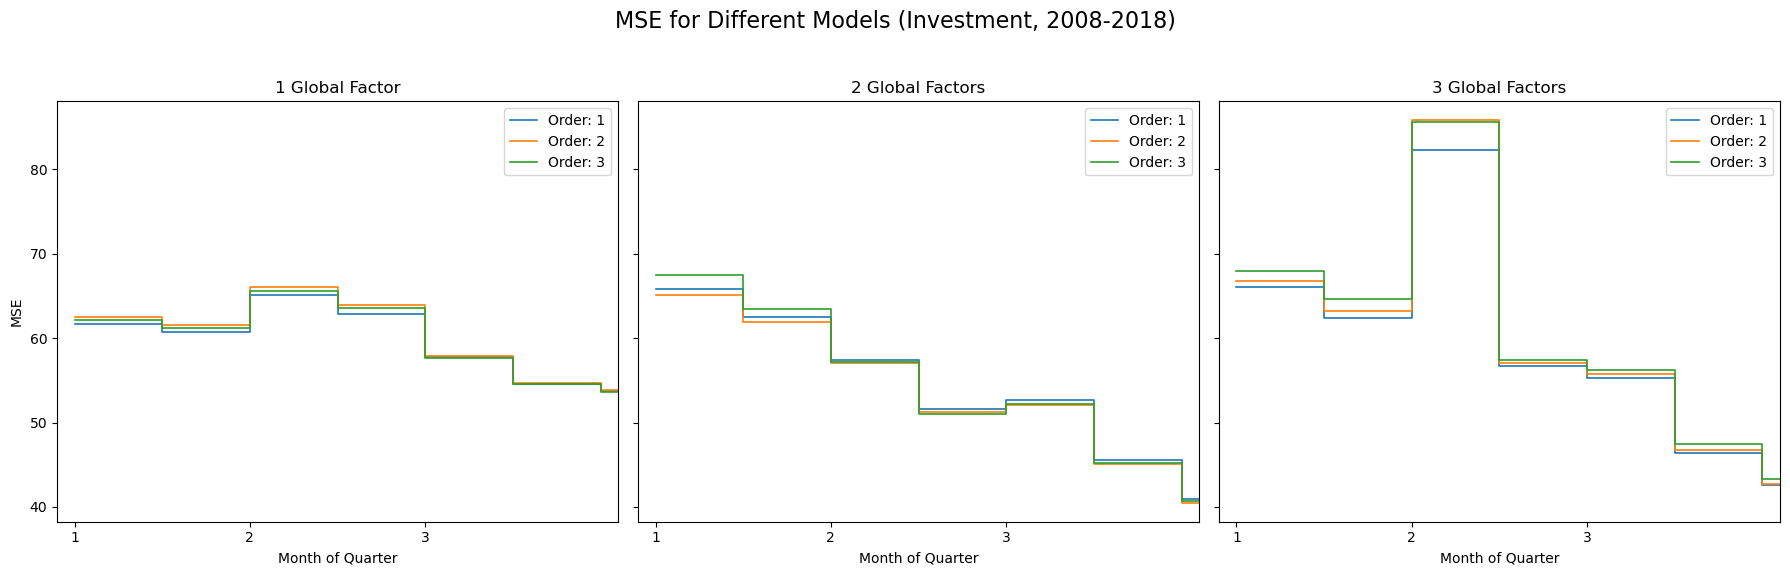

In [2]:
import os
import matplotlib.pyplot as plt
import pandas as pd

vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]
q_var = 'Investment'
text_type = "topics"
estimation_period = "2007"
num_topics = "200"
source = "all"

# Define a mapping for each vintage to a numeric x-value
x_mapping = {
    "M1-01": 1.0,
    "M1-16": 1.5,
    "M2-01": 2.0,
    "M2-16": 2.5,
    "M3-01": 3.0,
    "M3-16": 3.5,
    "M4-01": 4.0
}

# Construct x values based on the vintages
x_values = [x_mapping[col] for col in vintage_col_names]
# Extend the x array so that the last step extends to the end of the x-axis
x_extended = x_values.copy()
x_extended.append(4.1)  # extend x-axis to 4.1

# Define the directory containing MSE files
mse_dir = f"../MSE/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_{q_var}"

# Create a figure with 1 row and 3 columns of subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Loop over each number of global factors (1, 2, and 3)
for i, num_factors in enumerate(range(1, 4)):
    ax = axs[i]
    # Within each subplot, loop over factor orders 1 to 3
    for order in range(1, 4):
        # Construct file name based on the model's parameters
        factors_str = f"Global_{num_factors}_{order}"
        mse_file_name = f"MSE_{q_var}_{factors_str}.csv"
        mse_file_path = os.path.join(mse_dir, mse_file_name)
        
        # Load the MSE values from file
        mse_df = pd.read_csv(mse_file_path)
        # Construct y values based on the vintages
        y_values = [mse_df[col].iloc[0] for col in vintage_col_names]
        
        # Extend the y-values so the step function holds the last value
        y_extended = y_values.copy()
        y_extended.append(y_values[-1]) # Repeat the last value
        
        # Plot the step function for the current model
        ax.step(x_extended, y_extended, where='post', linewidth=1.2, 
                 label=f"Order: {order}")
        
    # Customize the subplot
    ax.set_xlabel("Month of Quarter")
    # Set ticks only at 1, 2, and 3 to mark the beginning of each month
    ax.set_xticks([1, 2, 3])
    ax.set_xlim(0.9, 4.1)
    ax.set_title(f"{num_factors} Global Factor{'s' if num_factors > 1 else ''}")
    if i == 0:  # Only the leftmost subplot gets the y-axis label
        ax.set_ylabel("MSE")
    ax.legend()

plt.suptitle(f"MSE for Different Models ({q_var}, 2008-2018)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
os.makedirs(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_{q_var}", exist_ok=True)
base_filename = os.path.join(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_{q_var}", f"DFM_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_2008-2018_{q_var}")
plt.savefig(f"{base_filename}.png", format="png")
plt.savefig(f"{base_filename}.eps", format="eps")

plt.show()

Plot MSE values for all models evaluated over the 2008–2010 and 2011-2018 periods.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


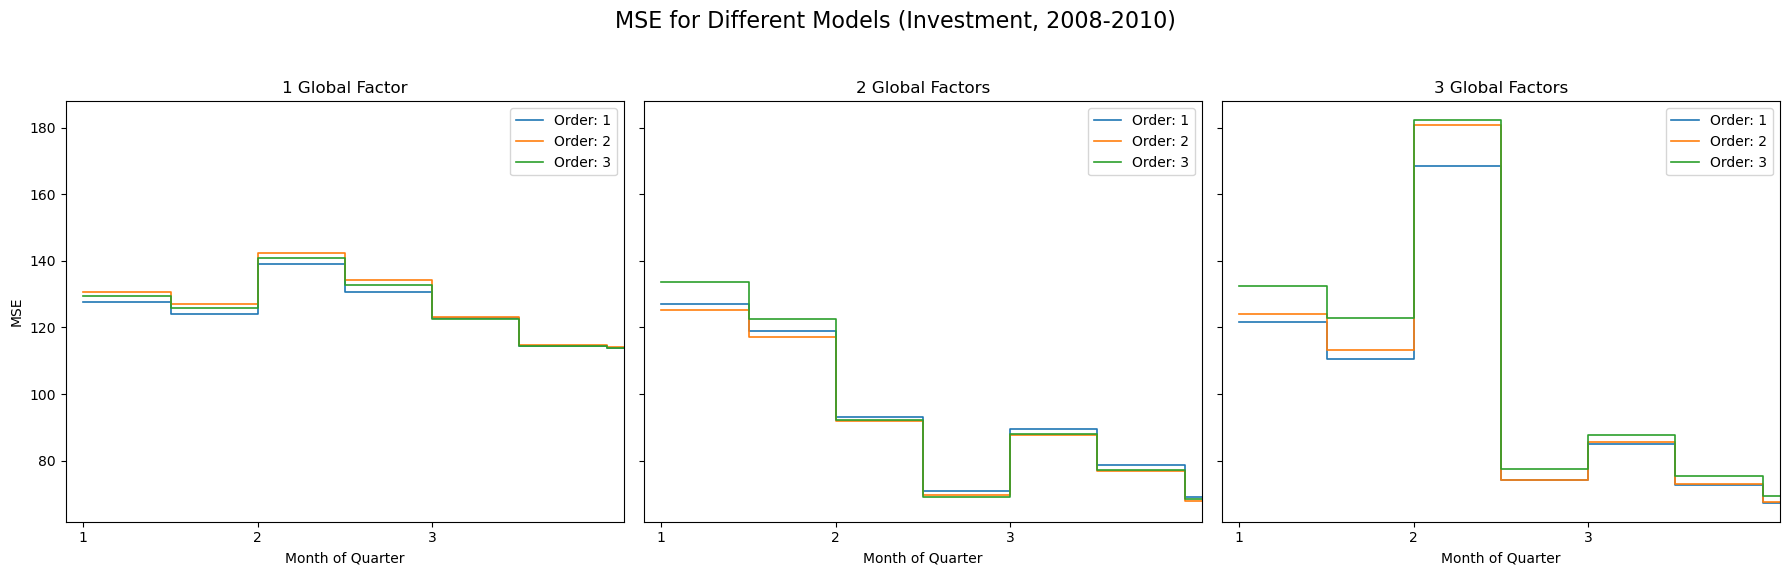

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


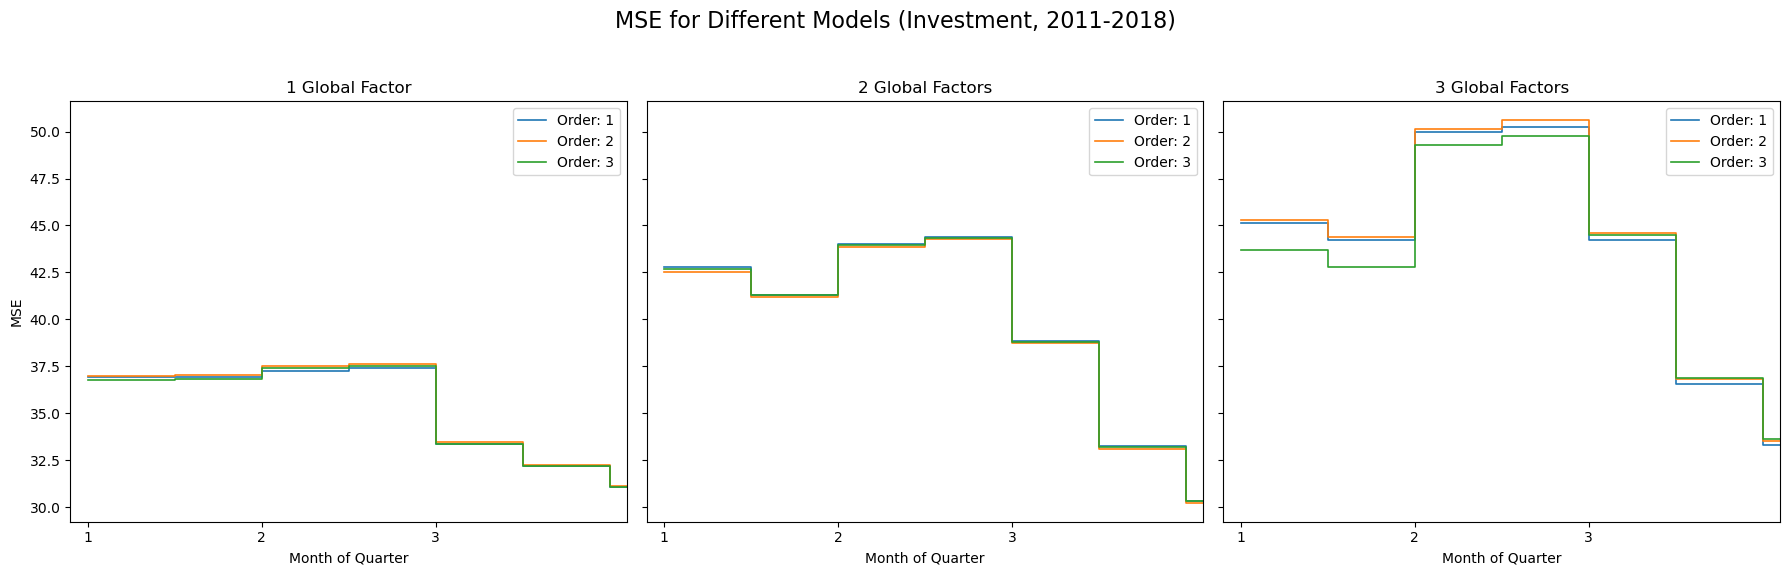

In [3]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def quarter_to_float(q_str):
    """
    Convert a string like 'YYYY-MM'
    into a float: e.g. 2008-03 -> 2008.00, 2008-06 -> 2008.25, etc.
    """
    year = int(q_str[:4])
    month = int(q_str[5:])
    # Map month to fraction of the year
    if month == 3:
        fraction = 0.00
    elif month == 6:
        fraction = 0.25
    elif month == 9:
        fraction = 0.50
    elif month == 12:
        fraction = 0.75
    return year + fraction

# Forecast variable and directories
q_var = 'Investment'
text_type = "topics"
estimation_period = "2007"
num_topics = "200"
source = "all"
forecasts_dir = f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_{q_var}"
actual_growth_file = f"../{q_var}_growth_actual.csv"

# Vintage columns
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Load actual growth data and convert 'date' to float
actual_growth = pd.read_csv(actual_growth_file)
actual_growth["date_float"] = actual_growth["date"].apply(quarter_to_float)
actual_growth.sort_values("date_float", inplace=True)

# Define two periods
periods = {
    "2008-2010": lambda df: df["date_float"] < 2011,
    "2011-2018": lambda df: df["date_float"] >= 2011
}

# Define a mapping for each vintage to a numeric x-value
x_mapping = {
    "M1-01": 1.0,
    "M1-16": 1.5,
    "M2-01": 2.0,
    "M2-16": 2.5,
    "M3-01": 3.0,
    "M3-16": 3.5,
    "M4-01": 4.0
}

# Construct x values based on the vintages
x_values = [x_mapping[col] for col in vintage_col_names]
# Extend the x array so that the last step extends to the end of the x-axis
x_extended = x_values.copy()
x_extended.append(4.1)  # extend x-axis to 4.1

# Loop over each period and create a separate figure
for period_label, period_filter in periods.items():
    
    # Create a figure with 1 row and 3 columns of subplots
    fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
    
    # Loop over each number of global factors (1, 2, and 3)
    for i, num_factors in enumerate(range(1, 4)):
        ax = axs[i]
        # Within each subplot, loop over factor orders 1 to 3
        for order in range(1, 4):
            # Construct forecast file name, e.g., "forecasts_Investment_Global_1_1.csv"
            factors_str = f"Global_{num_factors}_{order}"
            forecast_file_name = f"forecasts_{q_var}_{factors_str}.csv"
            forecast_file_path = os.path.join(forecasts_dir, forecast_file_name)
    
            # Load forecast data 
            forecasts = pd.read_csv(forecast_file_path, index_col=0)
            forecasts.index.name = "date"
            forecasts.reset_index(inplace=True)
            
            # Merge forecasts with actual growth 
            merged = pd.merge(forecasts, actual_growth, on="date", how="inner")
            merged["date_float"] = merged["date"].apply(quarter_to_float)
            merged.sort_values("date_float", inplace=True)
            
            # Filter merged data for the current period
            merged_period = merged[ period_filter(merged) ]
            
            # Calculate MSE for each vintage column over the filtered period
            mse_dict = {}
            for col in vintage_col_names:
                mse = ((merged_period[col] - merged_period["growth"]) ** 2).mean()
                mse_dict[col] = mse
                
            # Construct y values based on the vintages
            y_values = [mse_dict[col] for col in vintage_col_names]
            
            # Extend the y-values so the step function holds the last value
            y_extended = y_values.copy()
            y_extended.append(y_values[-1]) # Repeat the last value
            
            # Plot the step function for the current model (order)
            ax.step(x_extended, y_extended, where='post', linewidth=1.2, 
                    label=f"Order: {order}")
            
        # Customize the subplot
        ax.set_xlabel("Month of Quarter")
        # Set ticks only at 1, 2, and 3 to mark the beginning of each month
        ax.set_xticks([1, 2, 3])
        ax.set_xlim(0.9, 4.1)
        ax.set_title(f"{num_factors} Global Factor{'s' if num_factors > 1 else ''}")
        if i == 0:  # Only the leftmost subplot gets the y-axis label
            ax.set_ylabel("MSE")
        ax.legend()
   
    plt.suptitle(f"MSE for Different Models ({q_var}, {period_label})", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
    os.makedirs(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_{q_var}", exist_ok=True)
    base_filename = os.path.join(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_{q_var}", f"DFM_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_{period_label}_{q_var}")
    plt.savefig(f"{base_filename}.png", format="png")
    plt.savefig(f"{base_filename}.eps", format="eps")

    plt.show()

Plot forecasts vs actual growth values for all models and different time periods (2008-2010, 2008-2018, and 2011-2018).

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


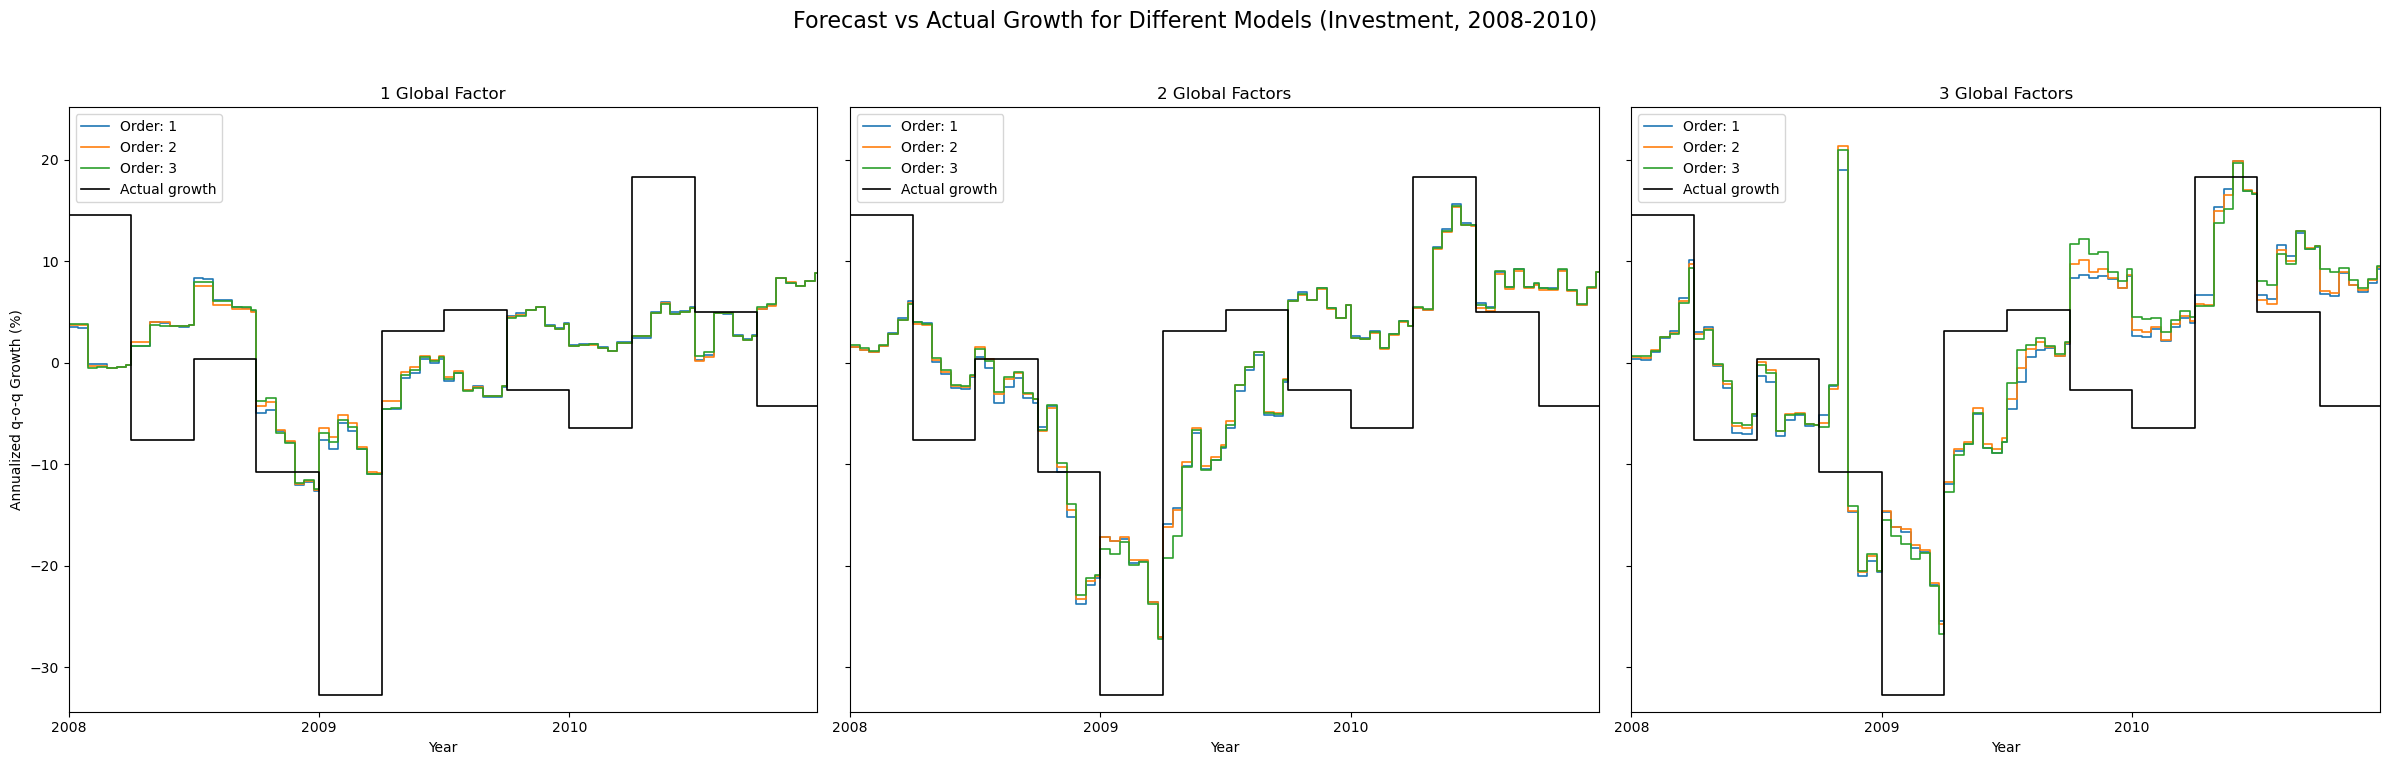

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


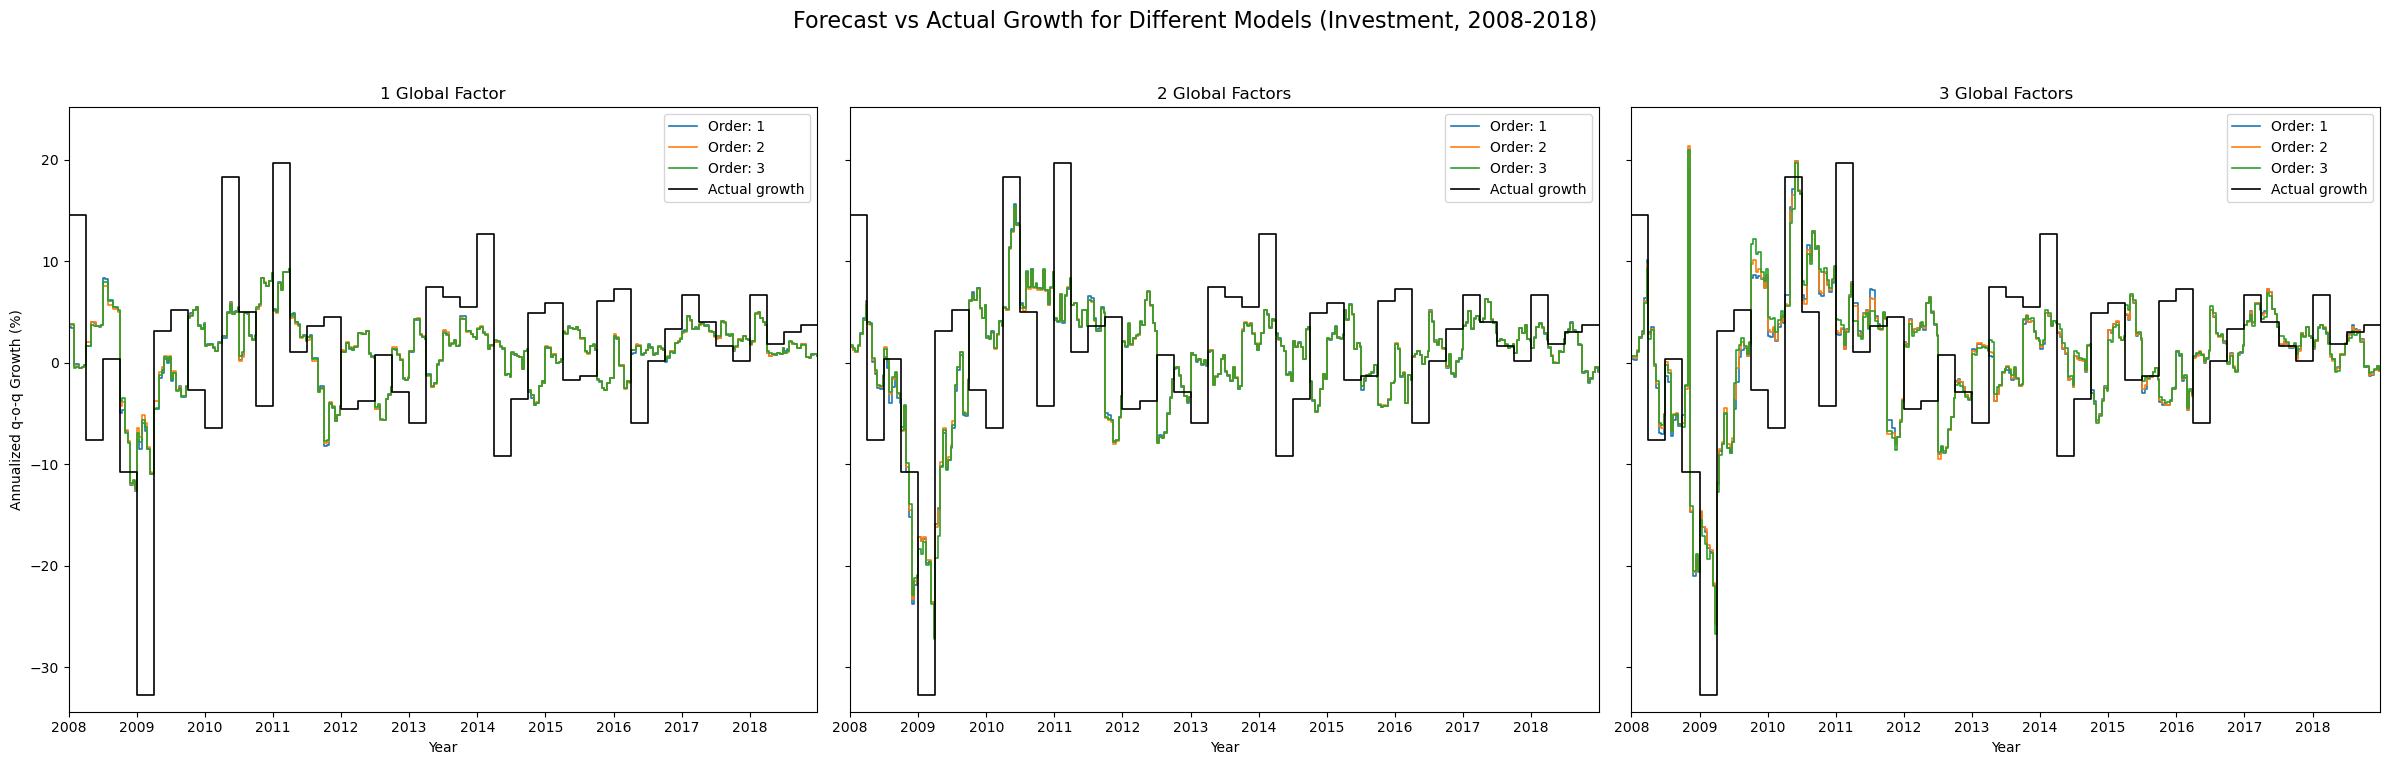

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


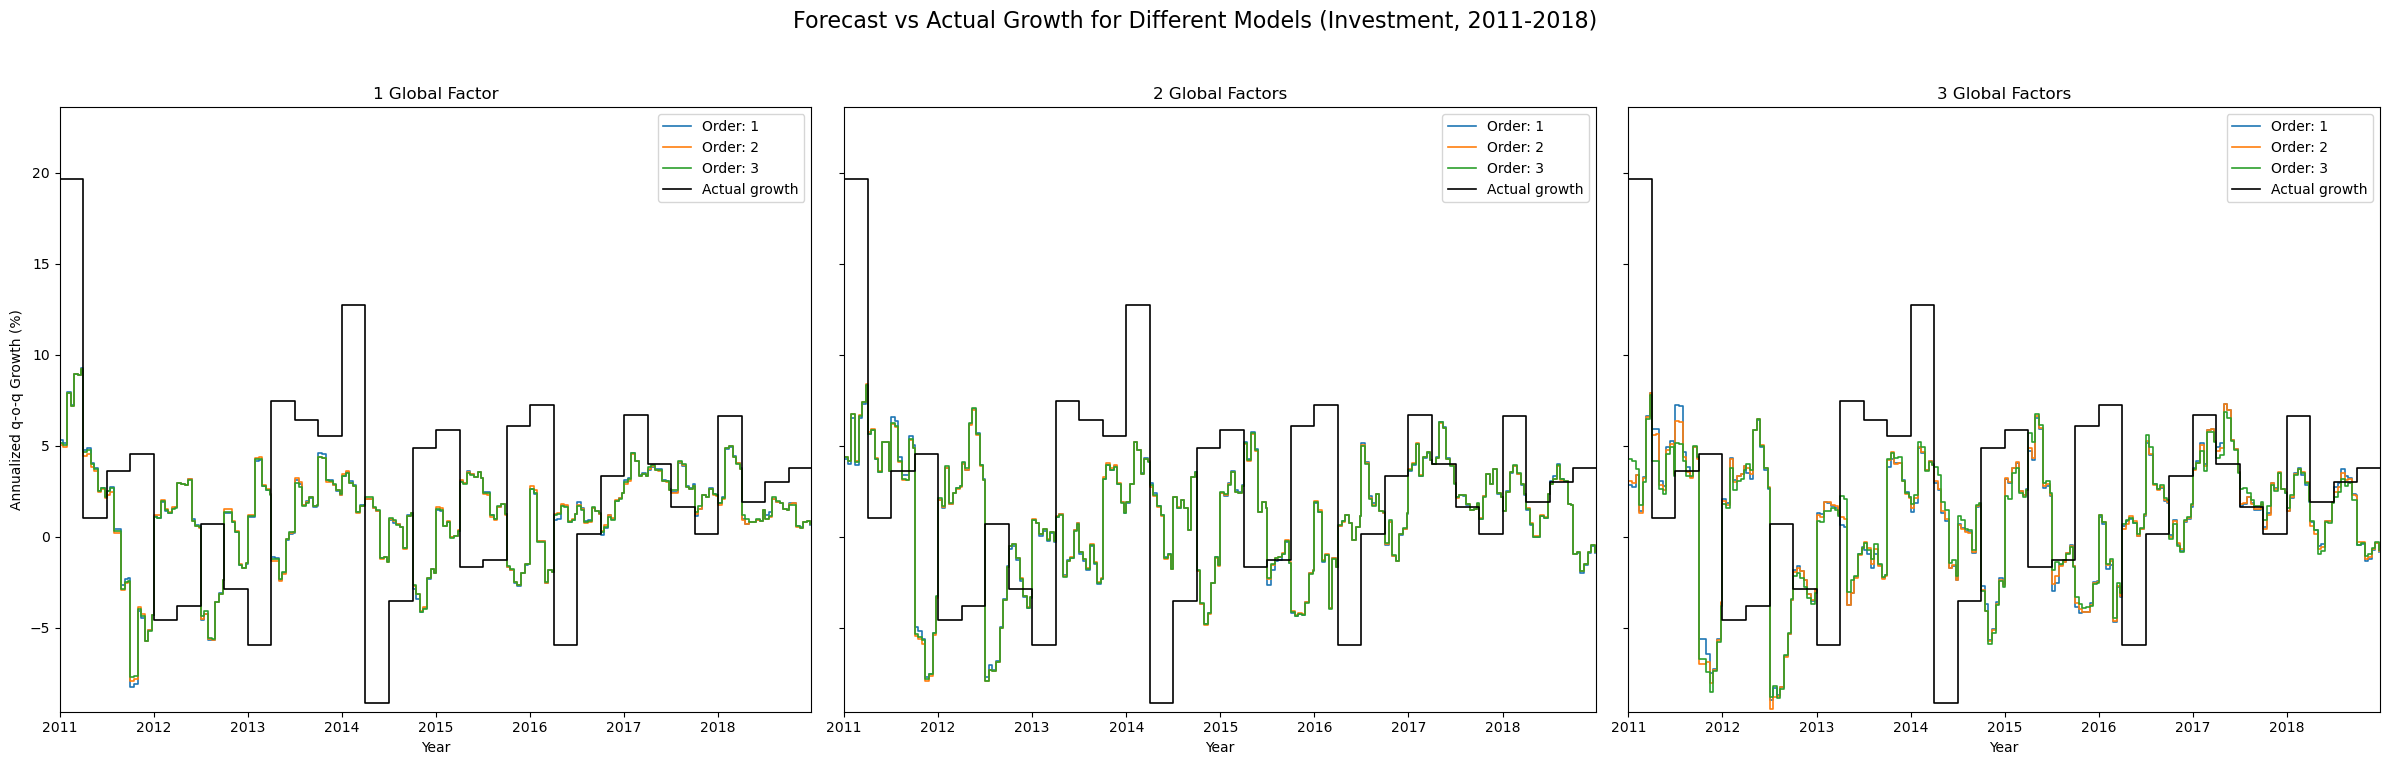

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Convert quarter strings like "2008-03" into a float (e.g. 2008.00 for Q1, 2008.25 for Q2, etc.)
def quarter_to_float(q_str):
    """
    Convert a string like 'YYYY-MM'
    into a float: e.g. 2008-03 -> 2008.00, 2008-06 -> 2008.25, etc.
    """
    year = int(q_str[:4])
    month = int(q_str[5:])
    # Map month to fraction of the year
    if month == 3:
        fraction = 0.00
    elif month == 6:
        fraction = 0.25
    elif month == 9:
        fraction = 0.50
    elif month == 12:
        fraction = 0.75
    return year + fraction

# Forecast variable and directories
q_var = 'Investment'
text_type = "topics"
estimation_period = "2007"
num_topics = "200"
source = "all"
forecasts_dir = f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_{q_var}"
actual_growth_file = f"../{q_var}_growth_actual.csv"

# Vintage columns
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Assign 7 small offsets within each quarter, so each quarter has 7 forecast points
offsets = np.linspace(0, 0.23, 7)

# Load actual growth data and convert 'date' to float
actual_growth = pd.read_csv(actual_growth_file)
actual_growth["date_float"] = actual_growth["date"].apply(quarter_to_float)
actual_growth.sort_values("date_float", inplace=True)

# Build x,y arrays for the actual growth
x_act = actual_growth["date_float"].tolist()
y_act = actual_growth["growth"].tolist()

# Define period configurations: x-axis limits and tick positions for each period
period_configs = {
    "2008-2010": {"xlim": (2008, 2010.99), "xticks": list(range(2008, 2011))},
    "2008-2018": {"xlim": (2008, 2018.99), "xticks": list(range(2008, 2019))},
    "2011-2018": {"xlim": (2011, 2018.99), "xticks": list(range(2011, 2019))}
}

# Loop over each period configuration to create and save separate plots
for period_label, config in period_configs.items():
    
    # Extend the actual growth arrays so that the step function continues until the end of the x-axis
    if period_label in ["2008-2018", "2011-2018"]:
        x_act_extended = x_act.copy()
        x_act_extended.append(config["xlim"][1])
        y_act_extended = y_act.copy()
        y_act_extended.append(y_act[-1])
    else:
        x_act_extended = x_act
        y_act_extended = y_act

    # Create a figure with 1 row and 3 columns for the three global factor counts
    fig, axs = plt.subplots(1, 3, figsize=(24, 8), sharey=True)

    # Loop over each global factor count (1, 2, and 3)
    for i, num_factors in enumerate([1, 2, 3]):
        ax = axs[i]

        # For each global factor count, plot forecasts for orders 1, 2, and 3
        for order in range(1, 4):

            # Construct forecast file name, e.g., "forecasts_Investment_Global_1_1.csv"
            factors_str = f"Global_{num_factors}_{order}"
            forecast_file_name = f"forecasts_{q_var}_{factors_str}.csv"
            forecast_file_path = os.path.join(forecasts_dir, forecast_file_name)

            # Load forecast data 
            forecasts = pd.read_csv(forecast_file_path, index_col=0)
            forecasts.index.name = "date"
            forecasts.reset_index(inplace=True)

            # Merge forecasts with actual growth dates
            merged = pd.merge(forecasts, actual_growth[['date']], on="date", how="inner")
            merged["date_float"] = merged["date"].apply(quarter_to_float)
            merged.sort_values("date_float", inplace=True)

            # Build forecast x and y arrays 
            x_fore = []
            y_fore = []
            for idx, row in merged.iterrows():
                base_x = row["date_float"]
                # For each of the 7 vintage columns, define an x-position and take that forecast value
                for j, col in enumerate(vintage_col_names):
                    x_fore.append(base_x + offsets[j])
                    y_fore.append(row[col])

            # Plot the forecast step curve for the current order
            ax.step(x_fore, y_fore, where='post', linewidth=1.2, label=f"Order: {order}")

        # Plot actual growth as a step plot in each subplot
        ax.step(x_act_extended, y_act_extended, where='post', color='black', linewidth=1.2, label="Actual growth")

        # Customize the subplot
        ax.set_xlabel("Year")
        ax.set_xlim(config["xlim"][0], config["xlim"][1])
        ax.set_xticks(config["xticks"])
        
        # Set y-axis limits based on the data within the period range
        x_min, x_max = config["xlim"]
        def filter_points(x_arr, y_arr, x_min, x_max):
            return [y for x, y in zip(x_arr, y_arr) if x_min <= x <= x_max]

        # Filter y-values
        y_filtered = filter_points(x_fore, y_fore, x_min, x_max)
        y_act_filtered = filter_points(x_act_extended, y_act_extended, x_min, x_max)
        
        # Combine all filtered y-values
        combined_y = y_filtered + y_act_filtered
        ax.set_ylim(1.05 * min(combined_y), 1.2 * max(combined_y))
        
        ax.set_title(f"{num_factors} Global Factor{'s' if num_factors > 1 else ''}")
        if i == 0:
            ax.set_ylabel("Annualized q-o-q Growth (%)")
        ax.legend()
        
    plt.suptitle(f"Forecast vs Actual Growth for Different Models ({q_var}, {period_label})", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
    os.makedirs(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_{q_var}", exist_ok=True)
    base_filename = os.path.join(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_{q_var}", f"DFM_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_forecast_vs_actual_{period_label}_{q_var}")
    plt.savefig(f"{base_filename}.png", format="png")
    plt.savefig(f"{base_filename}.eps", format="eps")

    plt.show()